Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# MONAI Auto3DSeg "Hello World" Example

In this notebook, we will provide a simple demonstration of how to use Auto3DSeg AutoRunner to process a simulated dataset and generate results within minutes.

## Setup environment

In [ ]:
!python -c "import monai" || pip install -U "monai-weekly[fire, nibabel, yaml, tqdm, einops]"
%env CUDA_VISIBLE_DEVICES=0

## Setup imports

In [ ]:
import os
import json
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

from monai.apps.auto3dseg import AutoRunner
from monai.config import print_config
from monai.data import create_test_image_3d

print_config()

## Simulate a special dataset

It is well known that AI takes time to train. To provide the "Hello World!" experience of Auto3D in this notebook, we will simulate a small dataset and run training only for multiple epochs. Due to the nature of AI, the performance shouldn't be highly expected, but the entire pipeline will be completed within minutes!

`sim_datalist` provides the information of the simulated datasets. It lists 12 training and 2 testing images and labels. The training data are split into 3 folds. Each fold will use 8 images to train and 4 images to validate. The size of the dimension is defined by the `sim_dim` .

In [ ]:
sim_datalist = {
    "testing": [
        {"image": "test_image_001.nii.gz", "label": "test_label_001.nii.gz"},
        {"image": "test_image_002.nii.gz", "label": "test_label_002.nii.gz"},
    ],
    "training": [
        {"fold": 0, "image": "tr_image_001.nii.gz", "label": "tr_label_001.nii.gz"},
        {"fold": 0, "image": "tr_image_002.nii.gz", "label": "tr_label_002.nii.gz"},
        {"fold": 0, "image": "tr_image_003.nii.gz", "label": "tr_label_003.nii.gz"},
        {"fold": 0, "image": "tr_image_004.nii.gz", "label": "tr_label_004.nii.gz"},
        {"fold": 1, "image": "tr_image_005.nii.gz", "label": "tr_label_005.nii.gz"},
        {"fold": 1, "image": "tr_image_006.nii.gz", "label": "tr_label_006.nii.gz"},
        {"fold": 1, "image": "tr_image_007.nii.gz", "label": "tr_label_007.nii.gz"},
        {"fold": 1, "image": "tr_image_008.nii.gz", "label": "tr_label_008.nii.gz"},
        {"fold": 2, "image": "tr_image_009.nii.gz", "label": "tr_label_009.nii.gz"},
        {"fold": 2, "image": "tr_image_010.nii.gz", "label": "tr_label_010.nii.gz"},
        {"fold": 2, "image": "tr_image_011.nii.gz", "label": "tr_label_011.nii.gz"},
        {"fold": 2, "image": "tr_image_012.nii.gz", "label": "tr_label_012.nii.gz"},
    ],
}

sim_dim = (64, 64, 64)

## Generate images and labels

Now we can use MONAI `create_test_image_3d` and `nib.Nifti1Image` functions to generate the 3D simulated images under the work_dir

In [ ]:
work_dir = "./helloworld_work_dir"
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

dataroot_dir = os.path.join(work_dir, "sim_dataroot")
if not os.path.isdir(dataroot_dir):
    os.makedirs(dataroot_dir)

datalist_file = os.path.join(work_dir, "sim_datalist.json")
with open(datalist_file, "w") as f:
    json.dump(sim_datalist, f)

for d in sim_datalist["testing"] + sim_datalist["training"]:
    im, seg = create_test_image_3d(
        sim_dim[0], sim_dim[1], sim_dim[2], rad_max=10, num_seg_classes=1, random_state=np.random.RandomState(42)
    )
    image_fpath = os.path.join(dataroot_dir, d["image"])
    label_fpath = os.path.join(dataroot_dir, d["label"])
    nib.save(nib.Nifti1Image(im, affine=np.eye(4)), image_fpath)
    nib.save(nib.Nifti1Image(seg, affine=np.eye(4)), label_fpath)

## Inspect the simulated data

Here we pick a slice of the 3D image in the test datasets to get an idea of the simulated images.

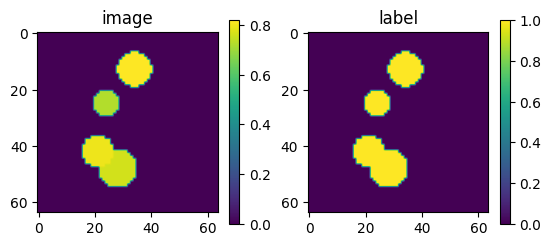

In [5]:
img_nib = nib.load(os.path.join(dataroot_dir, sim_datalist["testing"][0]["image"]))
lbl_nib = nib.load(os.path.join(dataroot_dir, sim_datalist["testing"][0]["label"]))
img = np.array(img_nib.dataobj)
lbl = np.array(lbl_nib.dataobj)
plt.subplot(1, 2, 1)
plt.imshow(img[32])
plt.title("image")
cbar = plt.colorbar(shrink=0.55)
plt.subplot(1, 2, 2)
plt.imshow(lbl[32])
plt.title("label")
cbar = plt.colorbar(shrink=0.55)

## Test the Auto3DSeg AutoRunner pipeline

`AutoRunner` provides an interface to run the Auot3DSeg pipeline. It will automatically configure four different neural networks and perform multi-fold training to achieve state-of-the-art performance. The module is highly configurable and only requires minimal user input to begin with. In this example, we want to complete the pipeline in two minutes, so we need to have some customizations.

Now we set up the `AutoRunner` with some settings:

In [ ]:
runner = AutoRunner(
    work_dir=work_dir,
    input={
        "modality": "MRI",
        "datalist": datalist_file,
        "dataroot": dataroot_dir,
    },
)

## Override the training parameters so that we can complete the pipeline in minutes

For demo purposes, below is a code block to convert num_epoch to iteration style and override all algorithms with the same training parameters.
If users would like to use more than one GPU, they can change the `CUDA_VISIBLE_DEVICES` environment variable, or just remove the line to use all available devices.
Users also need to ensure the number of GPUs is not greater than the number that the training dataset can be partitioned.

In [ ]:
max_epochs = 2

train_param = {
    "num_epochs_per_validation": 1,
    "num_images_per_batch": 2,
    "num_epochs": max_epochs,
    "num_warmup_epochs": 1,
}
runner.set_training_params(train_param)
runner.set_num_fold(num_fold=1)

## Start the data analysis, algorithm generation, training, and model ensemble

In [ ]:
runner.run()

## Inspect the algo ensembled predctions and compare it with the ground truth

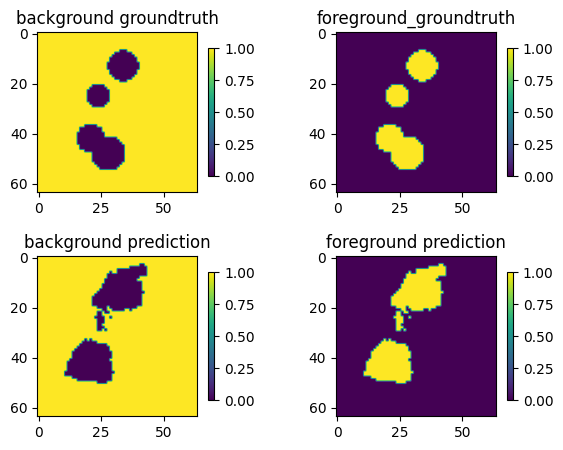

In [9]:
image_name = sim_datalist["testing"][0]["image"].split(".")[0]
prediction_nib = nib.load(os.path.join(work_dir, "ensemble_output", image_name + "_ensemble" + ".nii.gz"))
pred = np.array(prediction_nib.dataobj)

img_slice32 = lbl[32] == 0
label_slice32 = lbl[32] == 1
background_slice32 = pred[32, :, :, 0] if pred.ndim == 4 else pred[32] == 0
foreground_slice32 = pred[32, :, :, 1] if pred.ndim == 4 else pred[32] == 1

plt.subplot(2, 2, 1)
plt.imshow(img_slice32)
plt.title("background groundtruth")
cbar = plt.colorbar(shrink=0.8)
plt.subplot(2, 2, 2)
plt.imshow(label_slice32)
plt.title("foreground_groundtruth")
cbar = plt.colorbar(shrink=0.8)
plt.subplot(2, 2, 3)
plt.imshow(background_slice32)
plt.title("background prediction")
cbar = plt.colorbar(shrink=0.8)
plt.subplot(2, 2, 4)
plt.imshow(foreground_slice32)
plt.title("foreground prediction")
cbar = plt.colorbar(shrink=0.8)
# set the spacing between subplots
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

## Conclusion

Here we complete the entire pipeline. As you may notice, we can see the algorithms start to learn the datasets and the prediction of background and foreground voxels. Auto3DSeg and AutoRunner are highly configurable. To get better results, you can increase the training time, apply a different ensemble method, or use hyper-parameter optimization through the AutoRunner or Auto3DSeg module APIs.

As a "Hello World" notebook, we will end the experiment with simulated datasets here.